In [1]:
from RBM_surrogate import *
from Sampling_Quantum import *
from Sampling_MPO import *
from Sampling import *
from functools import partial

/home/cudaq/.local/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/cudaq/.local/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/cudaq/.local/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


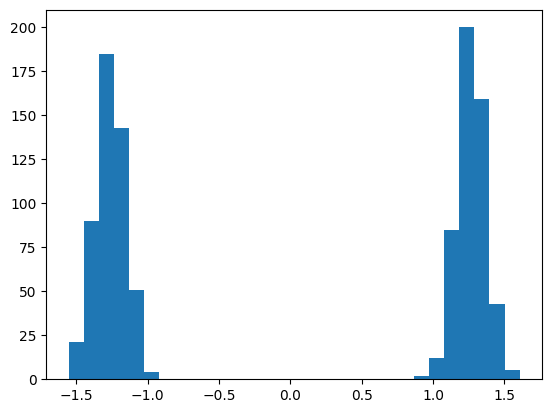

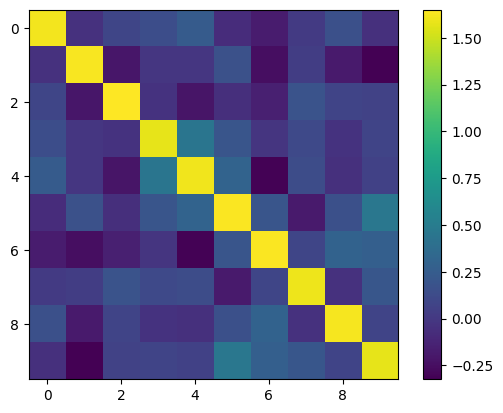

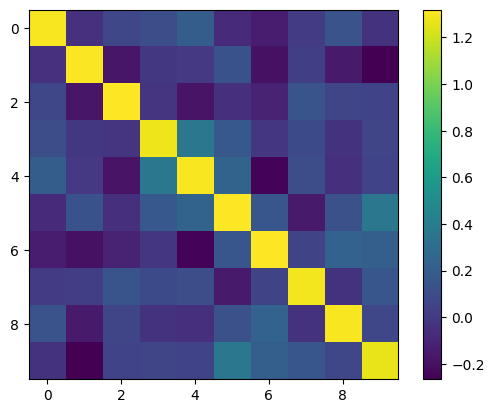

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def Cov_computer(sample_vector_stacks):
    #sample_vector_stacks is a row-wise stack of last k sample vectors. Each sample vector of length n
    X = np.asarray(sample_vector_stacks, dtype=float)
    #print(X)
    if X.shape[0] <= 1:
        return np.eye(X.shape[1])
    mean = X.mean(axis=0)
    #print(np.tile(mean, (X.shape[0],1)))
    diffs = X - np.tile(mean, (X.shape[0],1))
    return (diffs.T @ diffs) / (X.shape[0] - 1)

B = 100
n = 10

V = np.random.choice([-1,1], size=(B,n))

X = np.arctanh(np.clip(V, -0.999, 0.999)) / 3

Z = np.random.randn(B, n)
X_new = X + 0.1 * (Z) 

plt.hist(X_new.flatten(), bins=30)
plt.show()

plt.imshow(Cov_computer(X_new))
plt.colorbar()
plt.show()

Conc = np.zeros((2*B,n))
Conc[::2,:] = X_new
Conc[1::2,:] = V

plt.imshow(Cov_computer(Conc))
plt.colorbar()

In [2]:
import seaborn as sns

In [4]:
from importlib import reload

### Hamiltonian Diagonal Match Test 

In [5]:
N = 5
M = 2
rbm = RBM_surrogate(N,M)
rbm.build_surrogate()
prob_func = partial(prob_Ising_nv, N=N, poly=rbm.poly)  #, log_rho_max=rbm.log_rho_max)

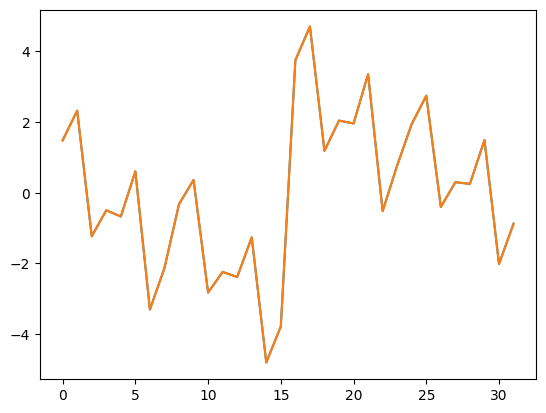

In [ ]:
s = enum(N)
gamma = 0

l = rbm.poly[1:1+N] 
J = rbm.poly[1+N:].reshape(N, N) 
alpha = computing_norm_ratio(N, l, J)
plt.plot(alpha * Energy_Ising(s,N,rbm.poly))

full_Ham_mat = Learner_Ham(N, rbm.poly, gamma, type_of_Ham="with_mixer").to_matrix()  
plt.plot(np.real(np.diag(full_Ham_mat)))

### Spectral Gap Test

In [7]:
def get_abs_spectral_gap_from_transition_mat(Transition_mat):
    dist = np.sort(1-np.abs(scipy.linalg.eigvals(Transition_mat)))
    delta = np.min(dist[1:])

    return delta

In [8]:
def run_experiment(N, trials=100, beta=1):
    s = enum(N)
    quantum_gaps = []
    uniform_gaps = []

    for _ in range(trials):
        poly = np.zeros(1+N+N*N)
        poly[1:1+N] = np.random.randn(N)
        J = np.random.randn(N,N)
        J = (J + J.T) / 2
        poly[1+N:] = J.reshape(-1)

        Energy = Energy_Ising(s, N, poly)

        gamma, tot_time = np.random.uniform(0.25, 0.6), np.random.uniform(2, 20)

        full_Ham_mat = Learner_Ham(N, poly, gamma, type_of_Ham="with_mixer").to_matrix()  
        U_t = scipy.linalg.expm(1.0j*tot_time*full_Ham_mat)

        Proposal_quantum = np.abs(U_t)**2
        Transition_quantum = np.abs(get_transition_matrix_from_proposal(N, Proposal_quantum, Energy, acceptance_criteria='metropolis', beta=1))
        quantum_gaps.append(get_abs_spectral_gap_from_transition_mat(Transition_quantum))

        Proposal_uniform = np.ones((2**N,2**N))/(2**N)
        Transition_uniform = np.abs(get_transition_matrix_from_proposal(N, Proposal_uniform, Energy, acceptance_criteria='metropolis', beta=1))
        uniform_gaps.append(get_abs_spectral_gap_from_transition_mat(Transition_uniform))

    return quantum_gaps, uniform_gaps

In [9]:
quantum_gaps, uniform_gaps = run_experiment(8,100)

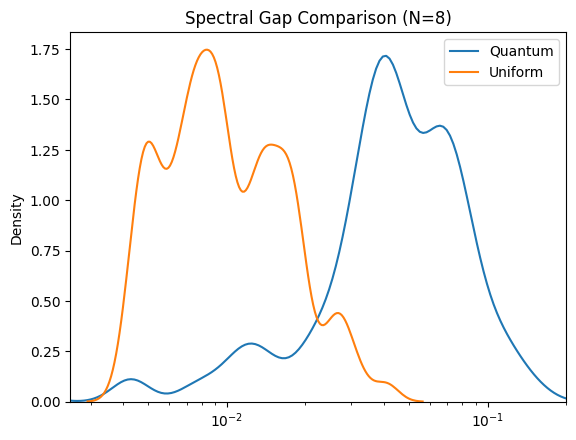

In [10]:
sns.kdeplot(quantum_gaps, bw_adjust=0.5, log_scale=True, label="Quantum")
sns.kdeplot(uniform_gaps, bw_adjust=0.5, log_scale=True, label="Uniform")
plt.legend()
plt.title("Spectral Gap Comparison (N=8)")
plt.xlim((2.5e-3,0.2))
plt.show()

### Sampling Comparison

In [7]:
N = 6
M = 4
rbm = RBM_surrogate(N,M)
rbm.build_surrogate()
prob_func = partial(prob_Ising_nv, N=N, poly=rbm.poly)  #, log_rho_max=rbm.log_rho_max)

In [8]:
sample_size = 80000

tm = time.time()
s = rbm.enum(N)
exact_dist = rbm.prob(s)
exact_dist = exact_dist / np.sum(exact_dist)
#plt.plot(1/4 - exact_dist)
print("Exact",  time.time()-tm)

prob_dist = {}
tm = time.time()
prob_dist['uniform'] = Sampling(N=N, prob_func=prob_func, sample_size=sample_size, burn=sample_size//10)
print("Uniform Sampling", time.time()-tm)

tm = time.time()
prob_dist['prop_exact'] = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10, compute_proposal_matrix=True, mode='Exact')
print("Proposal Matrix Exact", time.time()-tm)

tm = time.time()
prob_dist['prop_trot'] = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10, compute_proposal_matrix=True, mode='Trotter')
print("Proposal Matrix Trotter", time.time()-tm)


Exact 0.0019221305847167969
Uniform Sampling 9.456937074661255
Proposal Matrix Exact 0.8044230937957764
Proposal Matrix Trotter 2.57440447807312


In [9]:
sample_size = 10000
tm = time.time()
prob_dict, _ = Sampling_MPO(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10)
print("MPO Sampling", time.time()-tm)

Circuit creation time:  1.0085532665252686
 1│4│16│32│16│4│1 
+─●─●──●──●──●─●─+
  │ │  │  │  │ │  
MPO Sampling 42.58125281333923


In [10]:
# sample_size = 10000 #80000
# tm = time.time()
# prob_dict_quantum, _ = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10)
# print("Quantum Sampling", time.time()-tm)

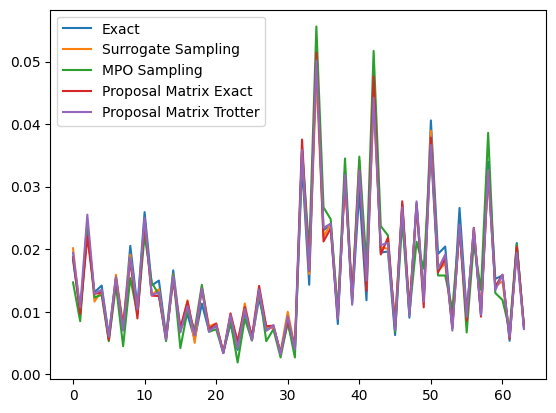

In [11]:
plt.plot(exact_dist, label='Exact')
plt.plot(prob_dist['uniform'], label="Surrogate Sampling")
#plt.plot(prob_dict_quantum.values(), label="Quantum Sampling")
plt.plot(prob_dict.values(), label="MPO Sampling")
plt.plot(prob_dist['prop_exact'], label="Proposal Matrix Exact")
plt.plot(prob_dist['prop_trot'], label="Proposal Matrix Trotter")

plt.legend()
plt.show()